# Openclassrooms Projet 7 :
## Implémenter un modèle de scoring

Notebook d'analyse exploratoire

Enzo Etelbert

### Sommaire

* [1. Chargement des données et analyse exploratoire](#1)
    * [1.1. Librairies importantes](#11)
    * [1.2. Chargement des données](#12)
    * [1.3. Description globale des données](#13)
* [2. Analyse détaillée des datasets de train et de test](#2)
    * [2.1. applicartion_train.csv & application_test.csv](#2_1)
        * [2.1.1. Création du pipeline](#2_11)
        * [2.1.5. Prédictions du modèle sur les données test et résultats](#2_15)

# 1. Chargement des données et analyse exploratoire <a class="anchor" id="1"></a>

## 1.1. Librairies importantes <a class="anchor" id="11"></a>

In [14]:
#Essential data science libraries
import pandas as pd
import seaborn as sns
import glob
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [17]:
# Define plots style
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':25,
     'ytick.labelsize':25,
     'axes.labelsize': 25,
     'legend.fontsize': 25,
     'axes.titlesize':45,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

## 1.2. Chargement des données <a class="anchor" id="12"></a>

In [3]:
%%time 
application_train = pd.read_csv('data/application_train.csv', index_col=0)
application_test = pd.read_csv('data/application_test.csv', index_col=0)
bureau = pd.read_csv('data/bureau.csv', index_col=0)
bureau_balance = pd.read_csv('data/bureau_balance.csv', index_col=0)
credit_card_balance = pd.read_csv('data/credit_card_balance.csv', index_col=0)
installments_payments = pd.read_csv('data/installments_payments.csv', index_col=0)
POS_CASH_balance = pd.read_csv('data/POS_CASH_balance.csv', index_col=0)
previous_application = pd.read_csv('data/previous_application.csv', index_col=0)

CPU times: user 15.3 s, sys: 2.58 s, total: 17.9 s
Wall time: 18.2 s


In [5]:
print("Définition des features :")
pd.set_option("max_colwidth", 400)
description = pd.read_csv('data/features_description.csv',  encoding="ISO-8859-1", index_col=0)
description

Définition des features :


,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...
217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was supposed to be paid (relative to application date of current loan),time only relative to the application
219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit paid actually (relative to application date of current loan),time only relative to the application
220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of previous credit on this installment,NaN


## 1.3. Description globale des données <a class="anchor" id="13"></a>

### Description globale des données

In [5]:
def data_describe(folder):
    '''Check the number of rows, columns, missing values and duplicates.
       Count type of columns.
       Memory indication'''

    data_dict = {}
    for file in folder:
        if file != "./data/features_description.csv":
            data = pd.read_csv(file)
            data_dict[file] = [data.shape[0], 
                               data.shape[1],
                                round(data.isna().sum().sum()/data.size*100, 2),
                                round(data.duplicated().sum().sum()/data.size*100, 2),
                                data.select_dtypes(include=['object']).shape[1],
                                data.select_dtypes(include=['float']).shape[1],
                                data.select_dtypes(include=['int']).shape[1],
                                data.select_dtypes(include=['bool']).shape[1],
                                round(data.memory_usage().sum()/1024**2, 3)]

            comparative_table = pd.DataFrame.from_dict(data = data_dict, 
                                                       columns = ['Rows', 'Columns', '%NaN', '%Duplicate', 
                                                                  'object_dtype','float_dtype', 'int_dtype', 
                                                                  'bool_dtype', 'MB_Memory'], 
                                                       orient='index')
    return(comparative_table)

#### Aperçu des dimensions des datasets, valeurs manquantes, type de données etc.

In [6]:
#Data description
data_describe(folder = glob.glob('./data/*.csv'))

,Rows,Columns,%NaN,%Duplicate,object_dtype,float_dtype,int_dtype,bool_dtype,MB_Memory
./data/application_test.csv,48744,121,23.81,0.0,16,65,40,0,44.998
./data/POS_CASH_balance.csv,10001358,8,0.07,0.0,1,2,5,0,610.435
./data/credit_card_balance.csv,3840312,23,6.65,0.0,1,15,7,0,673.883
./data/installments_payments.csv,13605401,8,0.01,0.0,0,5,3,0,830.408
./data/application_train.csv,307511,122,24.40,0.0,16,65,41,0,286.227
./data/bureau.csv,1716428,17,13.50,0.0,3,8,6,0,222.620
./data/previous_application.csv,1670214,37,17.98,0.0,16,15,6,0,471.481
./data/bureau_balance.csv,27299925,3,0.00,0.0,1,0,2,0,624.846
./data/sample_submission.csv,48744,2,0.00,0.0,0,1,1,0,0.744


**Remarques :**

- application_test possède une colonne de moins que application_train car la cible (TARGET) n'est présente que dans le second
- Pour ces deux jdd, le taux de valeurs manquantes est autour de 25%
- Il y a des features de type object, cela signifie qu'il faudra les encoder

# 2. Analyse détaillée des datasets de train et de test <a class="anchor" id="2"></a>

Dans cette section, nous allons explorer en détail le contenu des données d'entraînement et de test. Nous allons étudier les distributions des variables, puis associer la TARGET avec le comportement des différentes features.

In [6]:
print('Training dataset shape: ', application_train.shape)
print('Testing dataset shape: ', application_test.shape)

Training dataset shape:  (307511, 121)
Testing dataset shape:  (48744, 120)


## 2.1. Etude de la cible : TARGET <a class="anchor" id="21"></a>

**NOTE :**

- 0 : prêt remboursé
- 1 : prêt non remboursé

DISTRIBUTION DE TARGET : 
0    282686
1     24825
Name: TARGET, dtype: int64


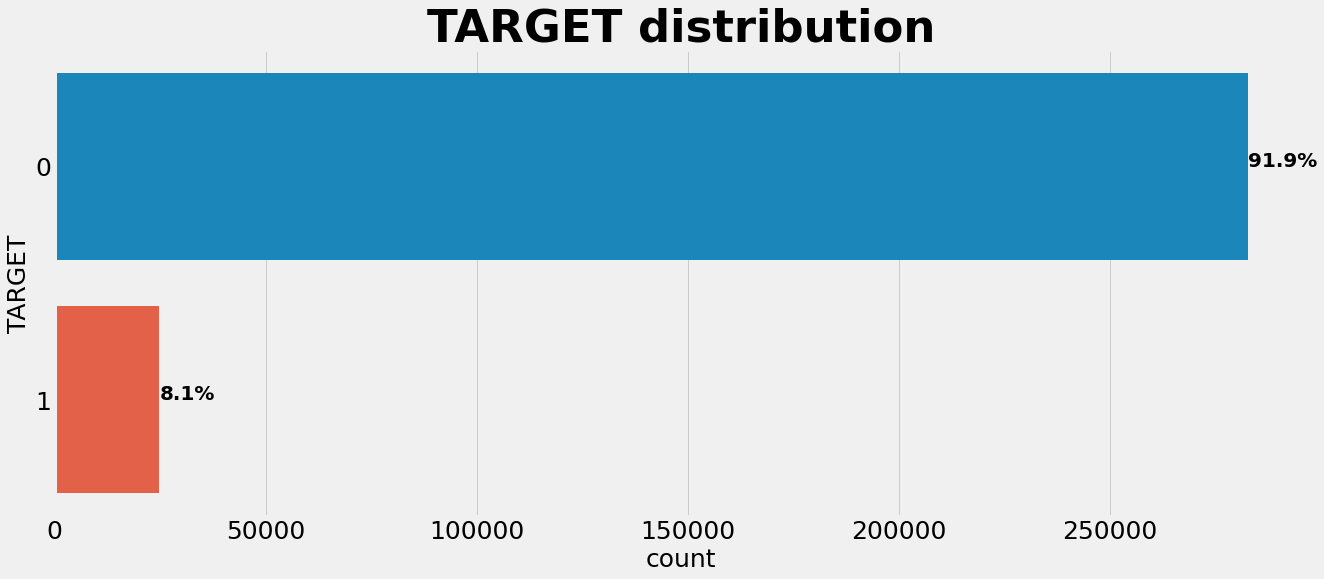

In [19]:
#Distribution of the Target Column
print(f"DISTRIBUTION DE TARGET : \n{application_train['TARGET'].value_counts()}")

ax, fig = plt.subplots(figsize=(20,8)) 
ax = sns.countplot(y='TARGET', data=application_train)
ax.set_title("TARGET distribution")

for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/len(application_train.TARGET))
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')
        
plt.show()

**Remarques :**

Les données sont très asymétriques. La grande majorité des prêts sont remboursés. Cela est un problème pour l'entraînement du modèle car il risque de retourner la même valeur à chaque prédiction du fait d'un grand nombre d'exemples identiques.

## 2.2. Types des données d'entraînement <a class="anchor" id="22"></a>

In [27]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 286.2+ MB


In [20]:
#Number of each type of column
application_train.dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

In [21]:
#Number of unique classes in each object column
application_train.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## 2.3. Valeurs manquantes dans les données d'entraînement <a class="anchor" id="23"></a>

In [35]:
def nan_check(data):
    '''Check Missing Values'''
    total = data.isnull().sum()
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 2))
    missing_data = pd.concat([total, percent_2], 
                             axis=1, keys=['Total', "NaN (%)"]).sort_values('NaN (%)', ascending=False)
    return missing_data

print('TOP 10 Missing values from Training dataset')
nan_check(application_train)[:10]

TOP 10 Missing values from Training dataset


,Total,NaN (%)
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
COMMONAREA_MEDI,214865,69.87
NONLIVINGAPARTMENTS_AVG,213514,69.43
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_MEDI,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_MEDI,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35
LIVINGAPARTMENTS_MODE,210199,68.35


In [37]:
print("Nb of columns in the training sample: " + str(len(nan_check(application_train))))

print("Nb of columns in the training sample with missing values: " + 
      str(len(nan_check(application_train)[nan_check(application_train)['Total']!=0])))

Nb of columns in the training sample: 121
Nb of columns in the training sample with missing values: 67


## 2.4. Analyse des valeurs (outliers, valeur atypiques ou aberrantes) <a class="anchor" id="24"></a>

### 2.4.1. Age des clients : DAYS_BIRTH <a class="anchor" id="241"></a>

In [38]:
#Client's age in days at the time of application (def. from HomeCredit_columns_description.csv)
application_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [39]:
(application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

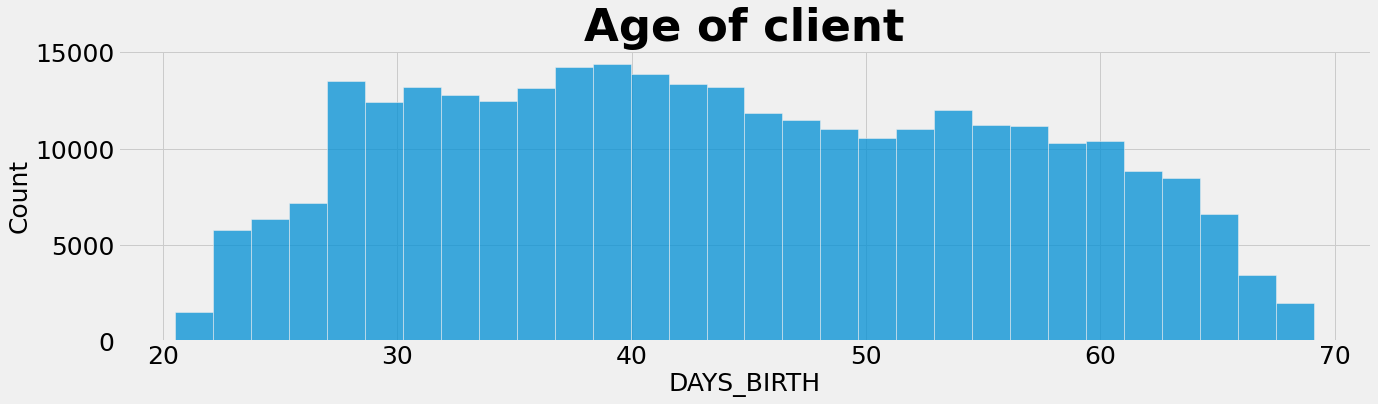

In [41]:
plt.figure(figsize=(20, 5))
sns.histplot((application_train['DAYS_BIRTH'] / -365), bins = 30).set_title('Age of client')
plt.show()

### days employed

In [49]:
#How many days before the application the perso... (def. from HomeCredit_columns_description.csv)
(application_train['DAYS_EMPLOYED']/365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

In [48]:
(application_test['DAYS_EMPLOYED']/365).describe()

count    48744.000000
mean       184.891415
std        395.475362
min        -47.843836
25%         -7.972603
50%         -3.542466
75%         -0.810959
max       1000.665753
Name: DAYS_EMPLOYED, dtype: float64

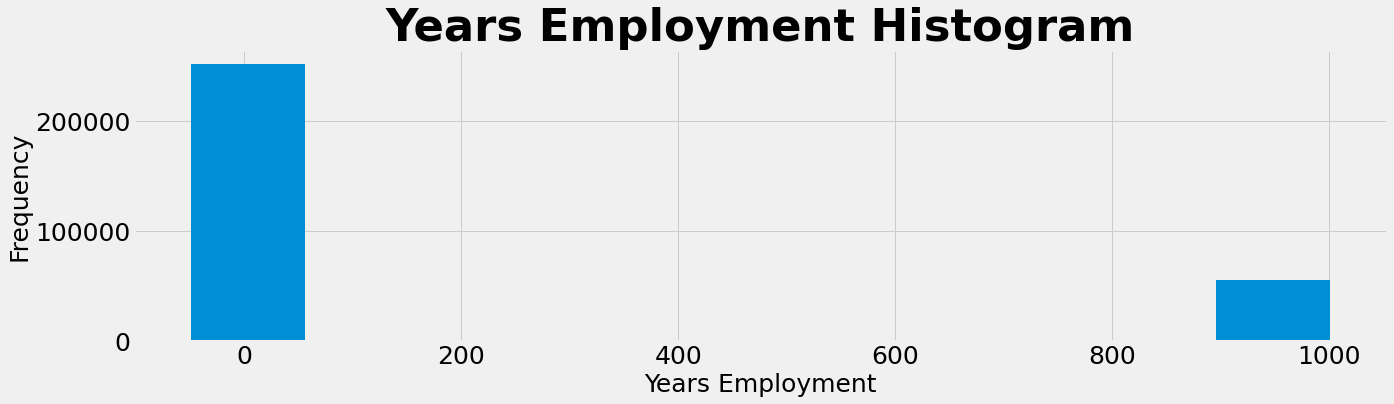

In [47]:
(application_train['DAYS_EMPLOYED']/365).plot.hist(title = 'Years Employment Histogram', figsize=(20,5));
plt.xlabel('Years Employment')
plt.show()